I initially started this notebook just to understand and write the decision tree from scratch but as I delved deeper into this dataset I learned that only using decision tree on the dataset itself did not lead to satisfied data analysis and an optimized model. I ended up writing a lot of different kinds of codes from scratch(which i could've just imported but that didn't feel right).

## Outline:
1. [Importing Libraries](#lib)
2. [Importing Data and Initial Analysis](#danalysis)
3. [Data Processing and Visualization](#dprocess)<br>
    [I. SMOTE](#smote)
4. [Model Implementation](#model)<br>
    [I. Decision Tree](#dt)
5. [Model Evaluation](#eval)
6. [Conclusion](#conc)

# 1. Importing Libraries
<a id = 'lib'></a>

I will be only using the following libraries only even though it is possible to write them from scratch too but my purpose of writing this notebook is to implement a Decision Tree Classifier from scratch.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# 2. Importing Data and Initial analysis
<a id = "danalysis"></a>

In [2]:
df = pd.read_csv("../input/red-wine-quality-cortez-et-al-2009/winequality-red.csv")

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


It appears that there are several columns which may/may not be related to the 'quality' of the wines.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


# 3. Data Processing and Visualization
<a id = "dprocess"></a>

Let's initially see the distribution of each feature.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

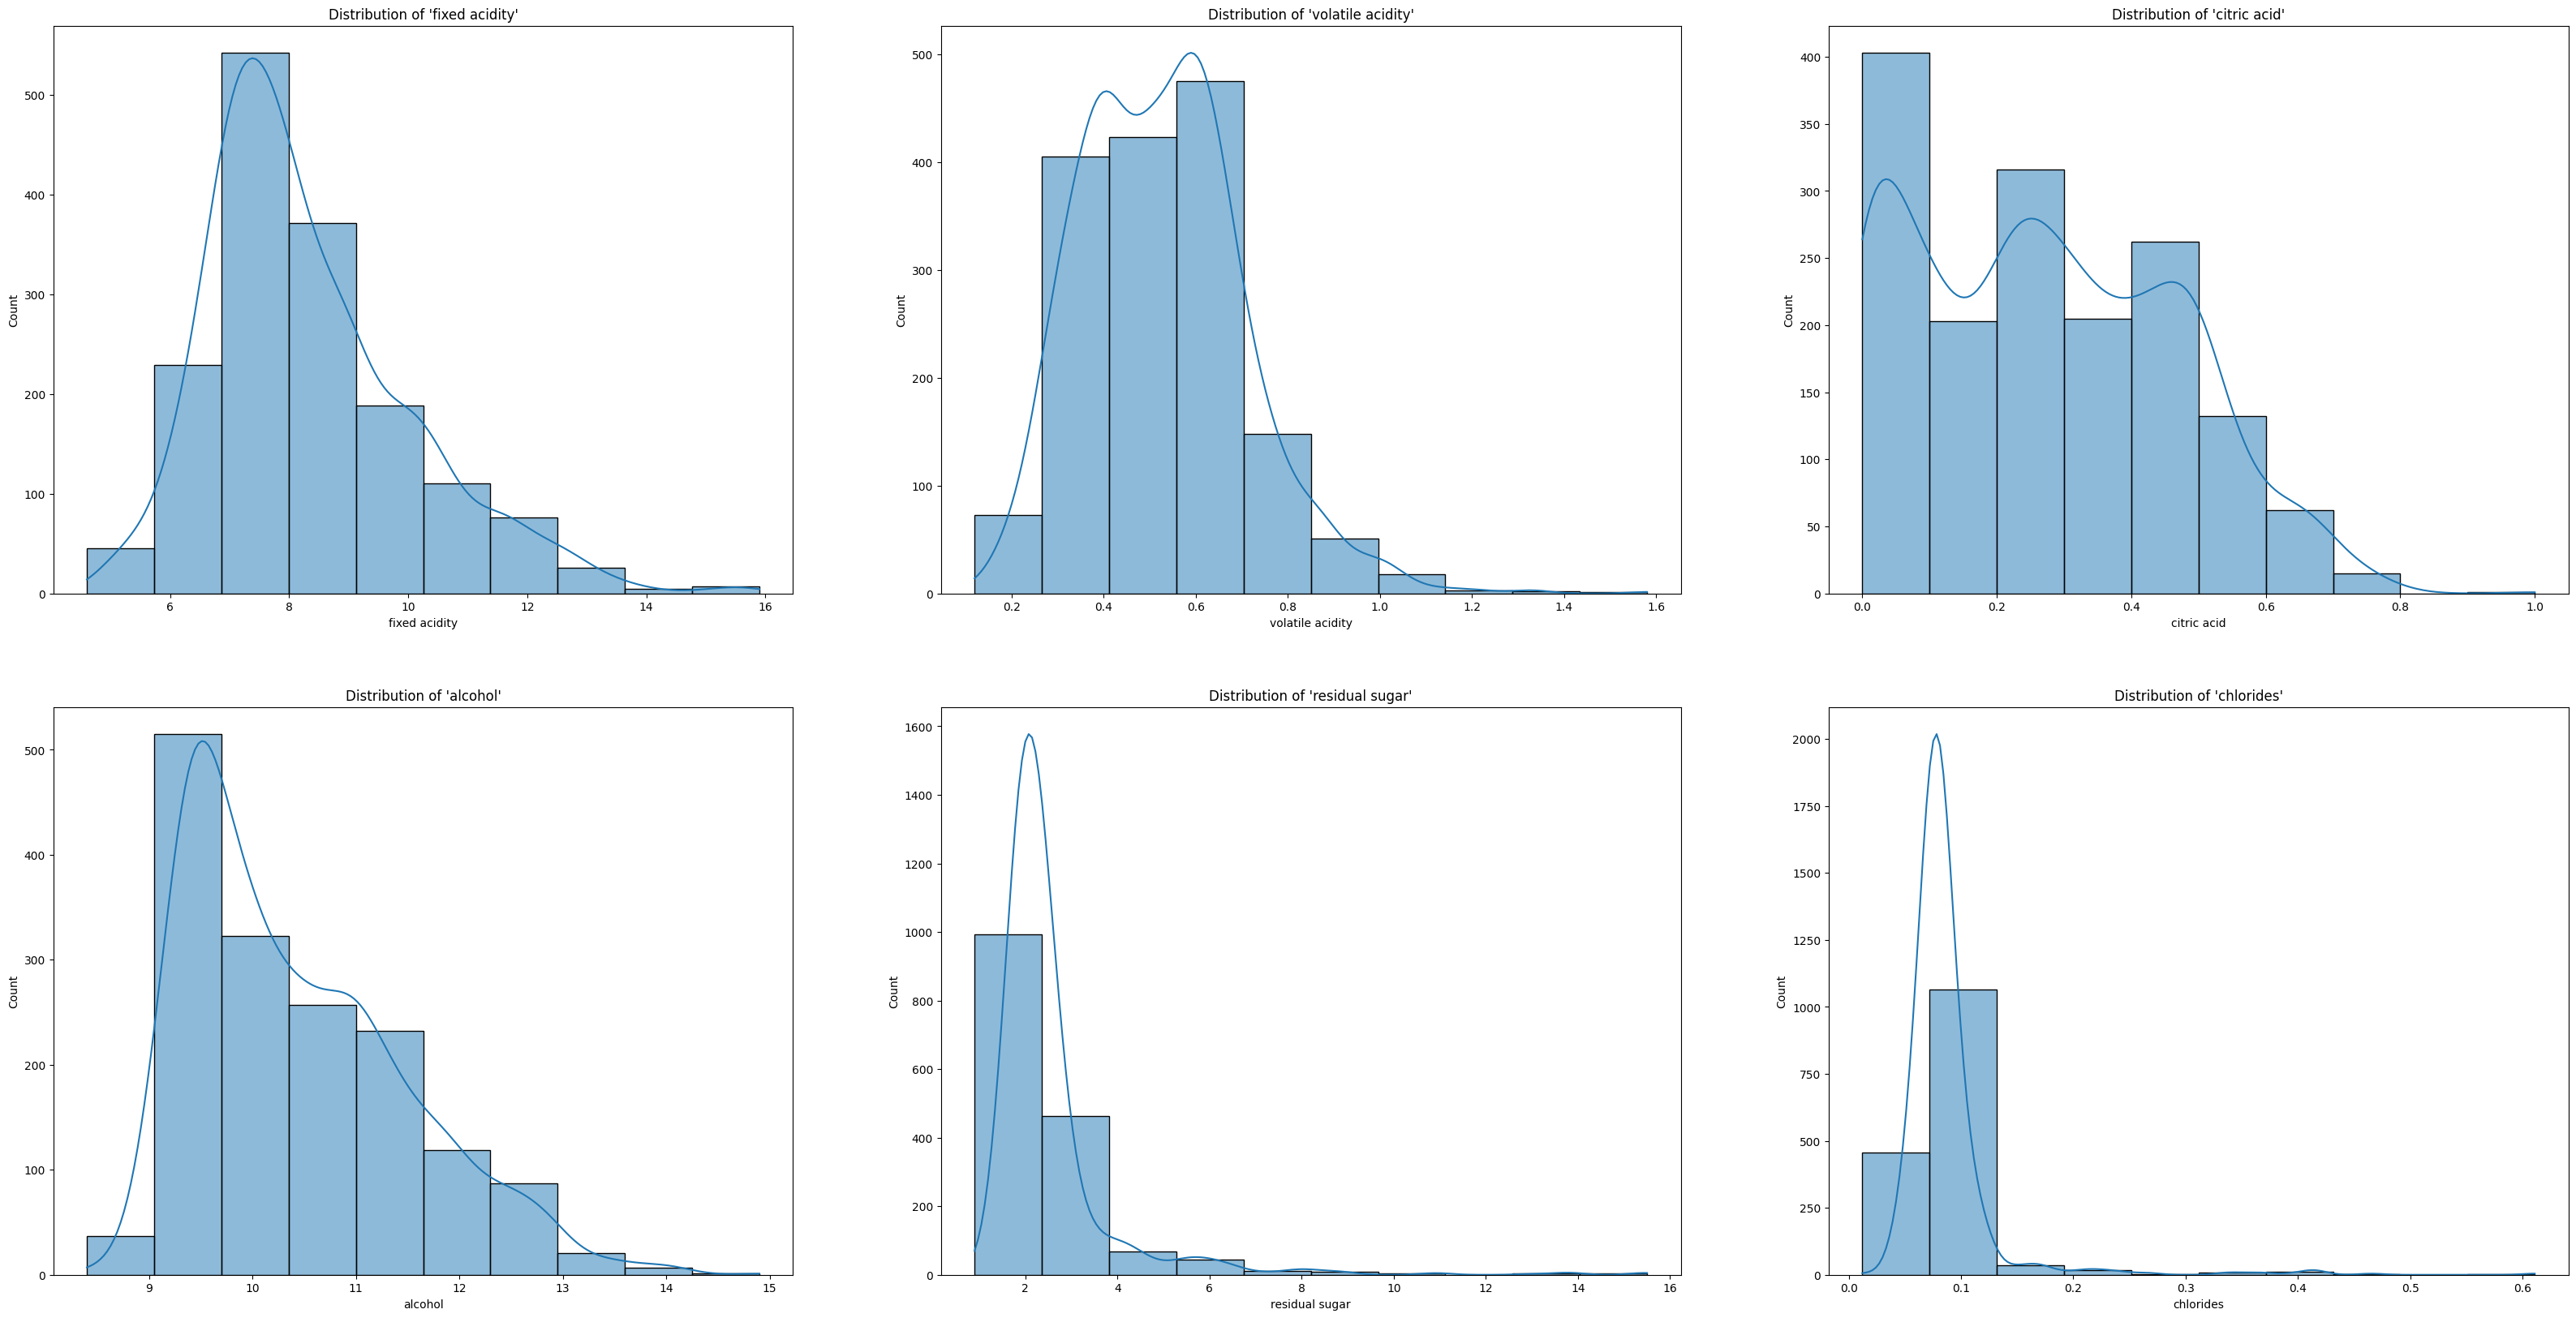

In [5]:
fig, axes = plt.subplots(2, 3, figsize = (40, 20))

sns.histplot(ax = axes[0, 0], x = df["fixed acidity"],
             bins = 10,
             kde = True,
             cbar = True).set(title = "Distribution of 'fixed acidity'");

sns.histplot(ax = axes[0, 1], x = df["volatile acidity"],
             bins = 10,
             cbar = True,
             kde = True).set(title = "Distribution of 'volatile acidity'");

sns.histplot(ax = axes[0, 2], x = df["citric acid"],
             bins = 10,
             kde = True,   
             cbar = True).set(title = "Distribution of 'citric acid'");

sns.histplot(ax = axes[1, 0], x = df["alcohol"],
             bins = 10,
             kde = True,
             cbar = True).set(title = "Distribution of 'alcohol'");

sns.histplot(ax = axes[1, 1], x = df["residual sugar"],
             bins = 10,
             cbar = True,
             kde = True).set(title = "Distribution of 'residual sugar'");

sns.histplot(ax = axes[1, 2], x = df["chlorides"],
             bins = 10,
             kde = True,   
             cbar = True).set(title = "Distribution of 'chlorides'");

Most of the features are not normally distributed. So that means we will have to use transformation like StandardScaler before putting them into the model.

Let's see what different values are there in the 'quality' column.

In [6]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3])

One important thing we should know is the count of each of these values in 'quality'. Why? If there's an imbalance in these values then our model will fail to identify patterns in the minority category(value with smaller counts).

In [7]:
df['quality'].value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

So from these you can see that there are a large number of wines with quality 5 and 6 and very few wines with quality 3, 4 and most importantly '8'. This is clearly an imbalanced dataset.\
Now if we go ahead without using any upsampling or downsampling techniques it is possible that our model might show a very high accuracy because there's an imbalance.\
Accuracy is the ratio of correct predictions over total predictions and what the model will do is that it will label all predictions to be the value of the majority category(5 and 6 in this case) and since there are very few of the other cases it will end up giving high accuracy.\
This is not what we want. We want the model to actually detect the patterns in the dataset which will make it understand "what exactly makes a wine good or bad?"

Now since we have categories which are minorities we will oversample them in order to get a balanced dataset. One very famous method to use is SMOTE(Synthetic Minority Oversampling Technique). Read more about SMOTE here: [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
> SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbours b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of two chosen instances a and b. 

Rather than importing SMOTE from imblearn I will write it from scratch.

## SMOTE from scratch
<a id = "smote"></a>

* I will start by defining the euclidean distance which will come handy when I will define the nearest neighbours.  
Here's the formula for the euclidean distance: \
$$d(x, y) = \sqrt{\sum_{i=1}^{n} (y_i - x_i)^2}$$

* Then I will define the k-nearest neighbours which takes in 'x' (point for which nearest neighbours are to be found), 'X' the dataset (which will be used to find the 'euclidean distances' and 'k' (number of neighbors) which I will keep as 5).

* Now for the main implementation of SMOTE, I will first start with determining the minority class label in the dataset (using np.unique and np.argmin). After than I will extract the indices and then for each minority class I will find its k nearest neighbors and generate the synthetic samples by interpolation.

* Finally I will combine them with the original dataset to create a balanced dataset.

In [8]:
def euclidean_distance(x1, x2):
    """
    Computes the Euclidean distance between two points.

    Parameters:
        x1 (array-like): First point.
        x2 (array-like): Second point.

    Returns:
        float: Euclidean distance between x1 and x2.
    """
    return np.sqrt(np.sum((x1 - x2) ** 2))

def nearest_neighbors(x, X, k):
    """
    Finds the k nearest neighbors of a point in a dataset.

    Parameters:
        x (array-like): Point for which neighbors are to be found.
        X (ndarray): Dataset.
        k (int): Number of neighbors to find.

    Returns:
        ndarray: Indices of k nearest neighbors.
    """
    distances = [euclidean_distance(x, x_) for x_ in X]
    return np.argsort(distances)[1:k+1]

def SMOTE(X, y, k, n_samples):
    """
    Applies the SMOTE algorithm to the dataset.

    Parameters:
        X (ndarray): Features.
        y (array-like): Labels.
        k (int): Number of nearest neighbors.
        n_samples (int): Number of synthetic samples to generate for each minority class sample.

    Returns:
        ndarray: Oversampled features.
        array-like: Oversampled labels.
    """
    X_resampled = []
    y_resampled = []

    minority_class = np.unique(y)[np.argmin(np.bincount(y))]
    majority_class = np.unique(y)[np.argmax(np.bincount(y))]

    minority_indices = np.where(y == minority_class)[0]

    for idx in minority_indices:
        nn_indices = nearest_neighbors(X[idx], X, k)
        for _ in range(n_samples):
            nn_index = np.random.choice(nn_indices)
            diff = X[nn_index] - X[idx]
            synthetic_sample = X[idx] + np.random.random() * diff
            X_resampled.append(synthetic_sample)
            y_resampled.append(minority_class)

    X_resampled = np.vstack((X, np.array(X_resampled)))
    y_resampled = np.hstack((y, np.array(y_resampled)))

    return X_resampled, y_resampled


# Shufflling the dataset for reproducibility
np.random.seed(42)  
df_shuffled_indices = np.random.permutation(len(df))
df_shuffled = df.iloc[df_shuffled_indices]

# Applying SMOTE
X_resampled, y_resampled = SMOTE(df_shuffled.drop('quality', axis=1).values, df_shuffled['quality'].values, k=5, n_samples=100)

# Concatenating the original and synthetic samples
synthetic_df = pd.DataFrame(X_resampled, columns=df_shuffled.drop('quality', axis=1).columns)
synthetic_df['quality'] = y_resampled

# Concatenate original and synthetic data
balanced_df = pd.concat([df_shuffled, synthetic_df])

# Print class counts to verify balance
print(balanced_df['quality'].value_counts())


quality
5    1362
6    1276
3    1020
7     398
4     106
8      36
Name: count, dtype: int64


In [9]:
df = balanced_df

Now that we have a balanced dataset let's check its heatmap to understand the correlations.

<Axes: >

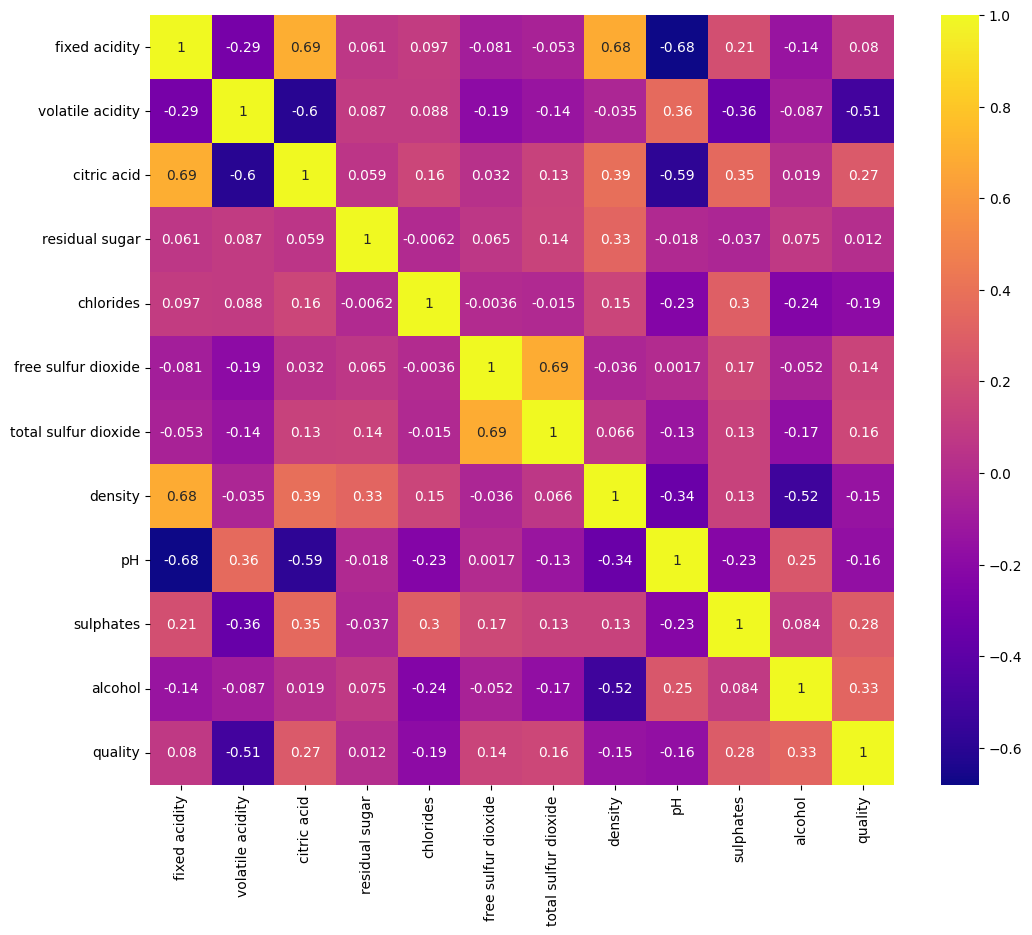

In [10]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.plasma)

It appears that 'fixed acidity' and 'residual sugar' are not much correlated with the 'quality'. So let's only select those columns which have the absolute value of correlation to be greater than 0.1.

In [11]:
selected_columns = df.corr()[abs(df.corr()['quality']) > 0.1].index.tolist()
df = df[selected_columns]
print(df.head())

      volatile acidity  citric acid  chlorides  free sulfur dioxide  \
803               0.56         0.08      0.114                 14.0   
124               0.50         0.17      0.082                 21.0   
350               0.67         0.22      0.107                 17.0   
682               0.46         0.31      0.078                 32.0   
1326              0.46         0.24      0.077                 18.0   

      total sulfur dioxide  density    pH  sulphates  alcohol  quality  
803                   46.0   0.9971  3.24       0.66      9.6        6  
124                  102.0   0.9960  3.39       0.48      9.5        5  
350                   34.0   1.0004  3.28       0.98      9.9        6  
682                   58.0   0.9980  3.33       0.54      9.8        5  
1326                  34.0   0.9948  3.39       0.60     10.6        6  


Now that we have the high correlated columns let's understand their distribution using boxplot which is a useful tool to detect the outliers in the dataset.

<Axes: xlabel='quality', ylabel='alcohol'>

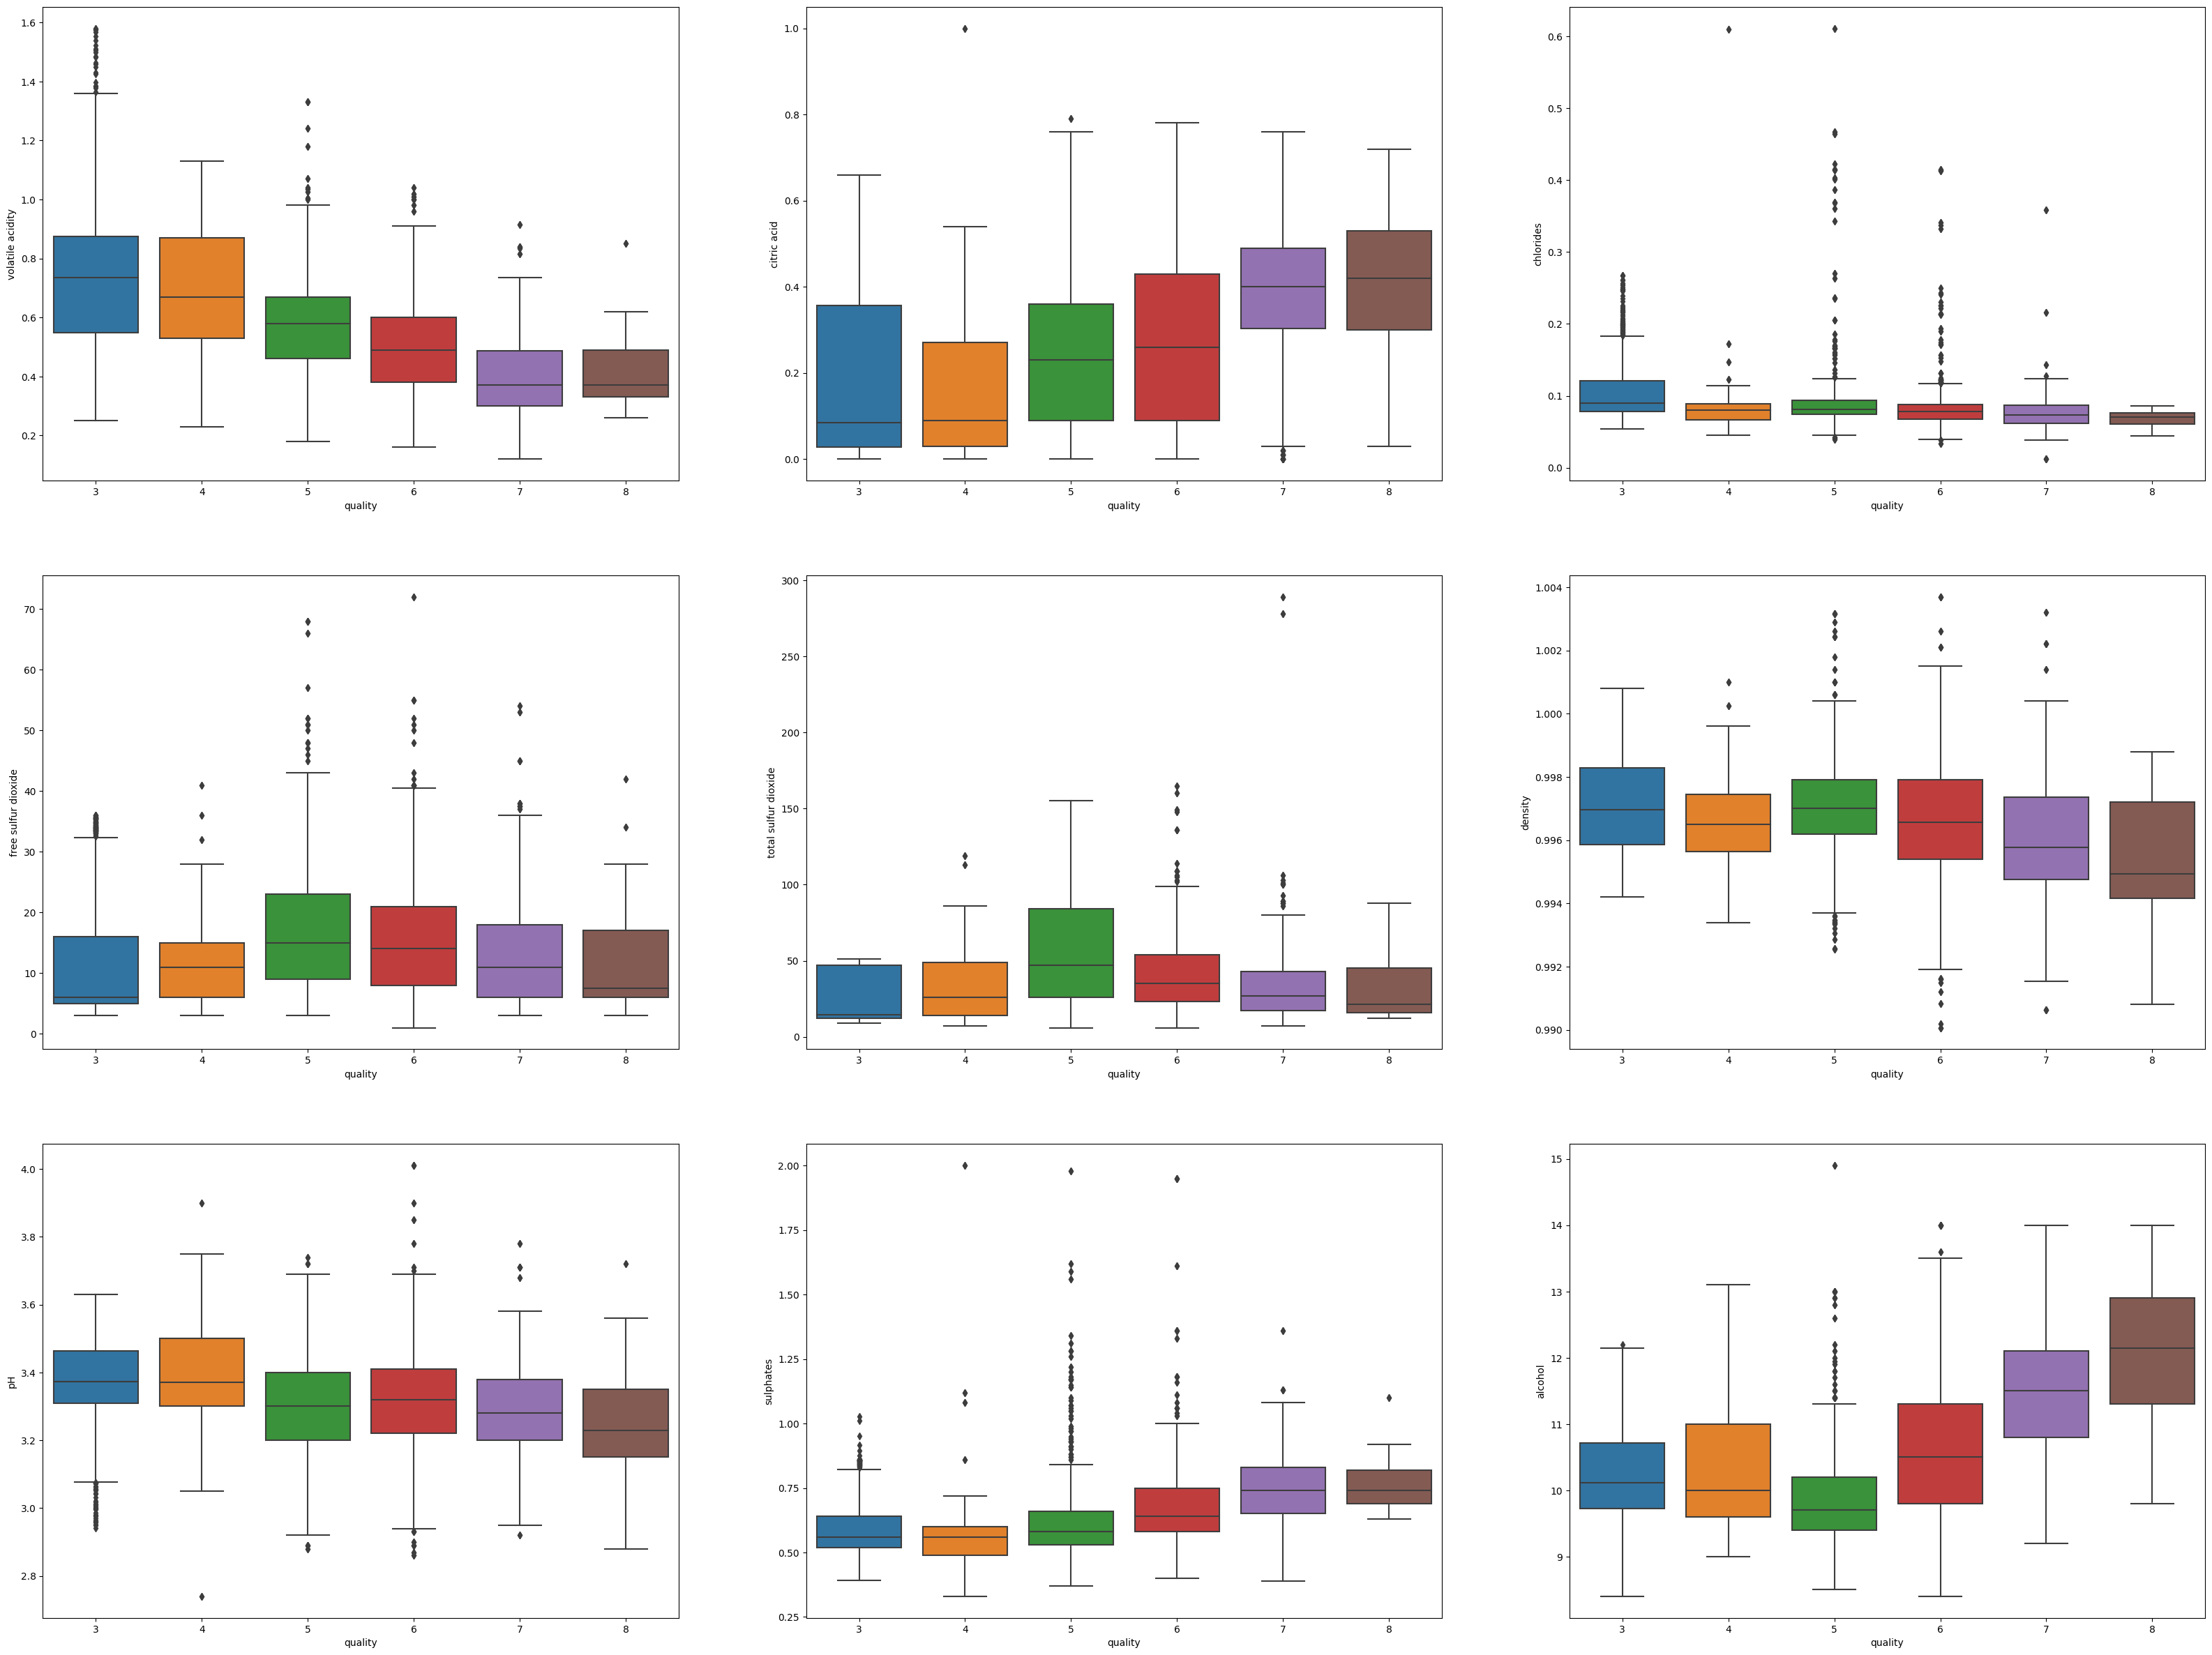

In [12]:
fig, axes = plt.subplots(3, 3, figsize = (40, 30))
sns.boxplot(ax = axes[0, 0], x = 'quality' ,y = 'volatile acidity', data = df);

sns.boxplot(ax = axes[0, 1], x = 'quality' ,y = 'citric acid', data = df);

sns.boxplot(ax = axes[0, 2], x = 'quality' ,y = 'chlorides', data = df);

sns.boxplot(ax = axes[1, 0], x = 'quality' ,y = 'free sulfur dioxide', data = df);

sns.boxplot(ax = axes[1, 1], x = 'quality' ,y = 'total sulfur dioxide', data = df);

sns.boxplot(ax = axes[1, 2], x = 'quality' ,y = 'density', data = df);

sns.boxplot(ax = axes[2, 0], x = 'quality' ,y = 'pH', data = df);

sns.boxplot(ax = axes[2, 1], x = 'quality' ,y = 'sulphates', data = df);

sns.boxplot(ax = axes[2, 2], x = 'quality' ,y = 'alcohol', data = df)



We can see that there are lots of outliers in this dataset(those small black dots are the outliers). These outlier will affect our model's training as they are the extreme values of the dataset which might mislead the model to learn a wrong pattern. So let's remove these outliers. 

I will be using IQR(Inter-Quartile Range) method to remove these outliers. You can read more about IQR here: [IQR](https://www.scribbr.com/statistics/interquartile-range/)

In [13]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Applying the function to remove outliers for each relevant column
columns_to_remove_outliers = selected_columns 
for col in columns_to_remove_outliers:
    df = remove_outliers(df, col)

#Removing rows with any NaN values after removing outliers
df = df.dropna()
df.reset_index(drop=True, inplace=True)

Now we want to build a classification model so we need to separate our 'quality' column into 2 parts. From the original data card, we are given that quality of 6 and above is considered to be 'Good' and remaining(i.e 5 and below) is considered to be 'Bad'. \
So I will create a new column named 'good_quality' which will have binary values where '0' denotes 'Bad' and '1' denotes 'Good' quality.

In [14]:
df['good_quality'] = df['quality'].apply(lambda x:0 if x<=5 else 1)
df = df.drop('quality', axis = 1)

/tmp/ipykernel_18/95447702.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['good_quality'], sort = True).sort_index()


Text(0, 0.5, 'Frequency')

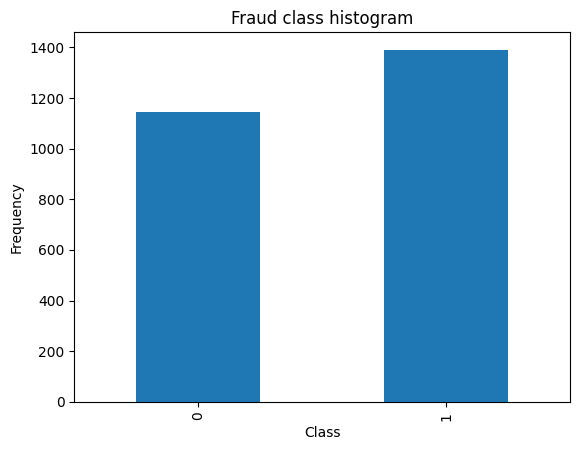

In [15]:
count_classes = pd.value_counts(df['good_quality'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [16]:
print('Bad quality', df['good_quality'].value_counts()[0])
print('Good quality', df['good_quality'].value_counts()[1])

Bad quality 1144
Good quality 1390


As you can see now, the counts of each category are nearly the same. I.e. We have removed the imbalance from the dataset. Hence, now our data is ready for the model training.

In [17]:
y = df['good_quality']
X = df.drop('good_quality', axis =1)

In [18]:
X.head(10)

,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.56,0.08,0.114,14.0,46.0,0.99710,3.24,0.66,9.6
1,0.50,0.17,0.082,21.0,102.0,0.99600,3.39,0.48,9.5
2,0.46,0.31,0.078,32.0,58.0,0.99800,3.33,0.54,9.8
3,0.46,0.24,0.077,18.0,34.0,0.99480,3.39,0.60,10.6
4,0.41,0.30,0.083,35.0,72.0,0.99700,3.44,0.52,9.4
5,0.78,0.08,0.093,10.0,19.0,0.99560,3.40,0.47,10.0
6,0.39,0.38,0.058,10.0,29.0,0.99620,3.26,0.74,9.8
7,0.61,0.11,0.066,18.0,28.0,0.99483,3.55,0.66,10.9
8,0.51,0.64,0.107,6.0,15.0,0.99730,3.09,0.66,11.8
9,0.48,0.08,0.064,18.0,34.0,0.99552,3.33,0.64,9.7


There's one small thing I missed after looking at this dataframe is that the scale of each feature is different and we also know that most of these columns are not 'Normally distributed'. In order to get good results lets first scale the features and normalise them.\
In order to do that one can just use sklearn's StandardScaler but here I will write it from scratch so that you'll know what's going on behind the scenes. \
I will create this new class 'StandardScaler' which will find mean and standard deviation of each features first and then it will normalize it by subtracting mean from each value and dividing that with the standard deviation.

In [19]:
class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)

    def transform(self, X):
        if self.mean_ is None or self.std_ is None:
            raise ValueError("Scaler has not been fitted yet.")
        return (X - self.mean_) / self.std_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [20]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [21]:
X

,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.201127,-0.937570,2.260702,-0.079843,0.249090,0.238479,-0.598908,0.272880,-0.824438
1,-0.152310,-0.462198,0.165952,0.721204,2.605865,-0.438332,0.518313,-1.324888,-0.928604
2,-0.387934,0.277269,-0.095892,1.979993,0.754113,0.792234,0.071425,-0.792298,-0.616105
3,-0.387934,-0.092465,-0.161353,0.377898,-0.255933,-1.176671,0.518313,-0.259709,0.217226
4,-0.682464,0.224450,0.231412,2.323299,1.343307,0.176951,0.890720,-0.969828,-1.032771
...,...,...,...,...,...,...,...,...,...
2529,-0.741370,1.122374,0.493256,-0.995325,-0.845127,0.619955,-1.269241,-1.147358,0.113059
2530,0.436751,-1.360123,-1.405111,-1.109761,-1.265979,0.607649,-1.045797,0.006586,0.008893
2531,0.642922,-0.831932,-0.423197,1.178946,0.838284,-0.204524,-0.226501,1.071764,0.529725
2532,0.554563,-1.043208,-0.161353,0.034593,1.890416,0.459981,1.412090,-0.792298,-0.928604


Now you can see that we have scaled these features and possibly also normalized them.

Now for splitting the dataset in training and testing, I will take the code of 'train_test_split' from my previous notebook .

In [22]:
def train_test_split(X, y, random_state=123, test_size=0.20):
    """
    Splits the data into training and testing sets.

    Parameters:
        X (numpy.ndarray or pandas.DataFrame): Features array of shape (n_samples, n_features).
        y (numpy.ndarray or pandas.Series): Target array of shape (n_samples,).
        random_state (int): Seed for the random number generator. Default is 42.
        test_size (float): Proportion of samples to include in the test set. Default is 0.2.

    Returns:
        Tuple[numpy.ndarray or pandas.DataFrame]: A tuple containing X_train, X_test, y_train, y_test.
    """
    # Convert input to numpy arrays if pandas DataFrames or Series are provided
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values

    # Ensure X and y have the same number of samples
    assert X.shape[0] == y.shape[0], "X and y must have the same number of samples."

    # Get number of samples
    n_samples = X.shape[0]

    # Set the seed for the random number generator
    np.random.seed(random_state)

    # Shuffle the indices
    shuffled_indices = np.random.permutation(np.arange(n_samples))

    # Determine the size of the test set
    test_size = int(n_samples * test_size)

    # Split the indices into test and train
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]

    # Split the features and target arrays into test and train
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
X_train.shape

(2028, 9)

In [25]:
y_train.shape

(2028,)

# 4. Model Implementation
<a id = "model"></a>

I'll start with creating a class named 'Node'. Imagine a decision tree as a bunch of boxes where each box makes a decision. Each box is called a "Node". In our code, we have a blueprint for these nodes. They can either have a condition to split data (like "Is the pH above 3.0?"), or they can be final boxes that give us an answer (like "Yes, it is of Good quality").

In [26]:
class Node():
    """
    A class representing a node in a decision tree.
    """

    def __init__(self, feature=None, threshold=None, left=None, right=None, gain=None, value=None):
        """
        Initializes a new instance of the Node class.

        Args:
            feature: The feature used for splitting at this node. Defaults to None.
            threshold: The threshold used for splitting at this node. Defaults to None.
            left: The left child node. Defaults to None.
            right: The right child node. Defaults to None.
            gain: The gain of the split. Defaults to None.
            value: If this node is a leaf node, this attribute represents the predicted value
                for the target variable. Defaults to None.
        """
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain
        self.value = value

## Key Concepts:

### Gini Impurity:
Gini impurity is a measure of the disorder or uncertainty in a set of labels. It quantifies the probability of incorrectly classifying an instance's label if it were randomly labeled according to the distribution of labels in the set.

Gini impurity $Gini(D)$ of a dataset $D$ with $K$ distinct classes is calculated using the following formula:
$$
Gini(D) = 1 - \sum_{i=1}^k p_i^2
$$
Where $p_{i}$ is the probability of randomly selecting an instance of class $i$ from the dataset $D$.


## Entropy:
Entropy is a measure of randomness or disorder in a set of labels. It quantifies the impurity of a dataset by measuring the uncertainty with the distribution of class labels.

The entropy $H(D)$ of a dataset $D$ with $K$ distinct classses is calculated using the formula:
$$
H(D) =  - \sum_{i=1}^K p_i log_2(p_i)
$$
Where $p_i$ is the probability of an instance belonging to class $i$ in the dataset $D$.


### Information Gain:
Information gain is a measure of the reduction in entropy or impurity achieved by splitting a dataset based on a particular feature. It quantifies the amount of uncertainty removed about the targer variable after the split.

The information gain $IG$ for splitting a dataset $D$ into subsets $D_1$ and $D_2$ based on a feature is calculated as:
$$
IG(D, feature) = Entropy(D) - \sum_{i=1}^2 \frac{|D_i|}{|D|} \times Entropy(D_i)
$$
Where $Entropy(D)$ is the entropy of dataset $D$, and $Entropy(D_i)$ is the entropy of subset $D_i$.

## Decision Tree algorithm: <a id = "dt"></a>
1. We start with the entire dataset at the root node of the tree. 
2. At each node, the algorithm will identify the feature and threshold that best splits the dataset based on a chosen criterion(Gini impurity or entropy).
3. It will divide the dataset into two subsets based on the chosen feature.
4. Now the steps 2 and 3 are repeated for each subset until a stopping criterion is met. After that it will assign the majority class label to leaf nodes.
5. Now comes creating a binary tree structure with split decisions at each node.
6. Finally it will traverse the tree from the root to a leaf node based on feature values to make predictions.

<div> <img src = "https://storage.googleapis.com/algodailyrandomassets/curriculum/Data_Science/Getting%20to%20Know%20Decision%20Trees/decision_tree.png" width = "500"/> </div>

In [27]:
class DecisionTree():
    """
    A decision tree classifier for binary classification problems.
    """

    def __init__(self, criterion='gini', splitter='best', min_samples_split=2, min_samples_leaf=1):
        """
        Constructor for DecisionTree class.

        Parameters:
            min_samples_split (int): Minimum number of samples required to split an internal node.
            min_samples_leaf (int): Minimum number of samples required to be at a leaf node.
            criterion (str): The function to measure the quality of a split. Default is 'gini'.
            splitter (str): The strategy used to choose the split at each node. Default is 'best'.
        """
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.splitter = splitter
        
    def gini(self, y):
        """
        Computes the Gini Impurity of the given label values.
        
        Parameters:
            y (ndarray): Input label values.
            
        Returns:
            gini_impurity (float): Gini impurity of the given label values.
        """
        gini_impurity = 1

        # Find the unique label values in y and loop over each value
        labels = np.unique(y)
        for label in labels:
            label_examples = y[y == label]
            pl = len(label_examples) / len(y)
            gini_impurity -= pl**2

        return gini_impurity
        
    def best_split(self, dataset, num_samples, num_features):
        """
        Finds the best split for the given dataset.

        Args:
        dataset (ndarray): The dataset to split.
        num_samples (int): The number of samples in the dataset.
        num_features (int): The number of features in the dataset.

        Returns:
        dict: A dictionary with the best split feature index, threshold, gain, 
          left and right datasets.
        """
    # dictionary to store the best split values
        best_split = {'gain': -1, 'feature': None, 'threshold': None,
                  'left_dataset': None, 'right_dataset': None}
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            thresholds = np.unique(feature_values)
            for threshold in thresholds:
                left_dataset, right_dataset = self.split_data(dataset, feature_index, threshold)
                if len(left_dataset) >= self.min_samples_leaf and len(right_dataset) >= self.min_samples_leaf:
                    y, left_y, right_y = dataset[:, -1], left_dataset[:, -1], right_dataset[:, -1]
                    information_gain = self.information_gain(y, left_y, right_y)
                    if information_gain > best_split["gain"]:
                        best_split["feature"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["left_dataset"] = left_dataset
                        best_split["right_dataset"] = right_dataset
                        best_split["gain"] = information_gain
        return best_split

    def split_data(self, dataset, feature, threshold):
        """
        Splits the given dataset into two datasets based on the given feature and threshold.

        Parameters:
            dataset (ndarray): Input dataset.
            feature (int): Index of the feature to be split on.
            threshold (float): Threshold value to split the feature on.

        Returns:
            left_dataset (ndarray): Subset of the dataset with values less than or equal to the threshold.
            right_dataset (ndarray): Subset of the dataset with values greater than the threshold.
        """
        left_dataset = []
        right_dataset = []
        
        # Loop over each row in the dataset and split based on the given feature and threshold
        for row in dataset:
            if row[feature] <= threshold:
                left_dataset.append(row)
            else:
                right_dataset.append(row)

        left_dataset = np.array(left_dataset)
        right_dataset = np.array(right_dataset)
        return left_dataset, right_dataset

    def entropy(self, y):
        """
        Computes the entropy of the given label values.

        Parameters:
            y (ndarray): Input label values.

        Returns:
            entropy (float): Entropy of the given label values.
        """
        entropy = 0

        # Find the unique label values in y and loop over each value
        labels = np.unique(y)
        for label in labels:
            label_examples = y[y == label]
            pl = len(label_examples) / len(y)
            entropy += -pl * np.log2(pl)

        # Return the final entropy value
        return entropy

    def information_gain(self, parent, left, right):
        """
        Computes the information gain from splitting the parent dataset into two datasets.

        Parameters:
            parent (ndarray): Input parent dataset.
            left (ndarray): Subset of the parent dataset after split on a feature.
            right (ndarray): Subset of the parent dataset after split on a feature.

        Returns:
            information_gain (float): Information gain of the split.
        """
        # set initial information gain to 0
        information_gain = 0
        if self.criterion == 'gini':
            parent_impurity = self.gini(parent)
        else:
            parent_impurity = self.entropy(parent)
        weight_left = len(left) / len(parent)
        weight_right = len(right) / len(parent)
        
        if self.criterion == 'gini':
            impurity_left, impurity_right = self.gini(left), self.gini(right)
        else:
            impurity_left, impurity_right = self.entropy(left), self.entropy(right)
            
        weighted_impurity = weight_left * impurity_left + weight_right * impurity_right
        
        information_gain = parent_impurity - weighted_impurity
        return information_gain

    
    def build_tree(self, dataset, current_depth=0):
        """
        Recursively builds a decision tree from the given dataset.

        Args:
            dataset (ndarray): The dataset to build the tree from.
            current_depth (int): The current depth of the tree.

        Returns:
            Node: The root node of the built decision tree.
        """
        # split the dataset into X, y values
        X, y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape

        # Check if any of the stopping conditions are met
        if n_samples < self.min_samples_split:
        # compute leaf node value
             leaf_value = self.calculate_leaf_value(y)
            # return leaf node value
             return Node(value=leaf_value)

        # Get the best split
        best_split = self.best_split(dataset, n_samples, n_features)

        # Check if gain isn't zero and if left and right datasets are not None
        if best_split["gain"] > 0 and best_split["left_dataset"] is not None and best_split["right_dataset"] is not None:
            # continue splitting the left and the right child. Increment current depth
             left_node = self.build_tree(best_split["left_dataset"], current_depth + 1)
             right_node = self.build_tree(best_split["right_dataset"], current_depth + 1)
            # return decision node
             return Node(best_split["feature"], best_split["threshold"],
                        left_node, right_node, best_split["gain"])

        # compute leaf node value
        leaf_value = self.calculate_leaf_value(y)
        # return leaf node value
        return Node(value=leaf_value)

    
    
    def calculate_leaf_value(self, y):
        """
        Calculates the most occurring value in the given list of y values.

        Args:
            y (list): The list of y values.

        Returns:
            The most occurring value in the list.
        """
        y = list(y)
        #get the highest present class in the array
        most_occuring_value = max(y, key=y.count)
        return most_occuring_value
    
    def fit(self, X, y):
        """
        Builds and fits the decision tree to the given X and y values.

        Args:
        X (ndarray): The feature matrix.
        y (ndarray): The target values.
        """
        y = y.reshape(-1, 1)
        dataset = np.concatenate((X, y), axis=1)  
        self.root = self.build_tree(dataset)

    def predict(self, X):
        """
        Predicts the class labels for each instance in the feature matrix X.

        Args:
        X (ndarray): The feature matrix to make predictions for.

        Returns:
        list: A list of predicted class labels.
        """
        # Create an empty list to store the predictions
        predictions = []
        # For each instance in X, make a prediction by traversing the tree
        for x in X:
            prediction = self.make_prediction(x, self.root)
            # Append the prediction to the list of predictions
            predictions.append(prediction)
        # Convert the list to a numpy array and return it
        np.array(predictions)
        return predictions
    
    def make_prediction(self, x, node):
        """
        Traverses the decision tree to predict the target value for the given feature vector.

        Args:
        x (ndarray): The feature vector to predict the target value for.
        node (Node): The current node being evaluated.

        Returns:
        The predicted target value for the given feature vector.
        """
        # if the node has value i.e it's a leaf node extract it's value
        if node.value != None: 
            return node.value
        else:
            #if it's node a leaf node we'll get it's feature and traverse through the tree accordingly
            feature = x[node.feature]
            if feature <= node.threshold:
                return self.make_prediction(x, node.left)
            else:
                return self.make_prediction(x, node.right)

In [28]:
dt = DecisionTree()

In [29]:
dt.fit(X_train, y_train)
dt_predict = dt.predict(X_test)

# 5. Model Evaluation
<a id = "eval"></a>


**In classification tasks, it's crucial to evaluate the performance of your model. There are several metrics that can help you understand how well your model is performing. Here are four commonly used classification metrics:**
## 1. Accuracy

**Formula:**
$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$
- **Accuracy** measures the proportion of correctly predicted instances out of all instances in a classification model.
- It is a widely used metric for evaluating classification performance.
- A higher accuracy value indicates a better classification model.
- However, accuracy alone may not provide a complete picture, especially in imbalanced datasets.

## 2. Precision

**Formula:**
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}
$$

- **Precision** measures the proportion of true positive predictions out of all positive predictions made by the model.
- It is a useful metric when the cost of false positives is high.
- Higher precision means the model makes fewer false positive predictions.

## 3. Recall (Sensitivity)

**Formula:**
$$
\text{Recall (Sensitivity)} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
$$

- **Recall**, also known as sensitivity or true positive rate, measures the proportion of true positive predictions out of all actual positive instances in the dataset.
- It is a valuable metric when it's essential to capture all positive instances.
- Higher recall means the model captures more of the actual positive instances.

## 4. F1-Score

**Formula:**
$$
\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision + Recall}}
$$

- The **F1-Score** is the harmonic mean of precision and recall.
- It provides a balance between precision and recall, making it a suitable metric when there is a trade-off between false positives and false negatives.
- A higher F1-Score indicates a model that achieves a balance between precision and recall.



In [30]:
class ClassificationMetrics:
    @staticmethod
    def accuracy_score(y_true, y_pred):
        """
        Computes the accuracy score.

        Parameters:
            y_true (array-like): True labels.
            y_pred (array-like): Predicted labels.

        Returns:
            float: Accuracy score.
        """
        correct = 0
        total = len(y_true)
        for true_label, pred_label in zip(y_true, y_pred):
            if true_label == pred_label:
                correct += 1
        return correct / total


    @staticmethod
    def confusion_matrix(y_true, y_pred):
        """
        Computes the confusion matrix.

        Parameters:
            y_true (array-like): True labels.
            y_pred (array-like): Predicted labels.

        Returns:
            ndarray: Confusion matrix.
        """
        classes = np.unique(np.concatenate((y_true, y_pred)))
        num_classes = len(classes)
        cm = np.zeros((num_classes, num_classes), dtype=int)
        for i in range(len(y_true)):
            true_label_index = np.where(classes == y_true[i])[0][0]
            pred_label_index = np.where(classes == y_pred[i])[0][0]
            cm[true_label_index][pred_label_index] += 1
        return cm
    

In [31]:
def classification_report(y_true, y_pred):
        """
        Computes the classification report.

        Parameters:
            y_true (array-like): True labels.
            y_pred (array-like): Predicted labels.

        Returns:
            str: Classification report.
        """
        cm = ClassificationMetrics.confusion_matrix(y_true, y_pred)
        classes = np.unique(np.concatenate((y_true, y_pred)))
        num_classes = len(classes)

        report = "              precision    recall  f1-score   support\n\n"
        for i in range(num_classes):
            precision = cm[i][i] / sum(cm[:, i]) if sum(cm[:, i]) > 0 else 0
            recall = cm[i][i] / sum(cm[i, :]) if sum(cm[i, :]) > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            support = sum(cm[i, :])
            report += f"Class {classes[i]}     {precision:.2f}       {recall:.2f}      {f1_score:.2f}       {support}\n"

        return report

In [32]:
dt_conf_matrix = ClassificationMetrics.confusion_matrix(y_test, dt_predict)
dt_acc_score = ClassificationMetrics.accuracy_score(y_test, dt_predict)


print("Decision Tree's accuracy score is:", dt_acc_score*100)
print(dt_conf_matrix)
print(classification_report(y_test, dt_predict))

Decision Tree's accuracy score is: 95.65217391304348
[[202  10]
 [ 12 282]]
              precision    recall  f1-score   support

Class 0.0     0.94       0.95      0.95       212
Class 1.0     0.97       0.96      0.96       294



We can see that the accuracy comes out to be around 96%!! Even the f1-score is good! \
Let's compare this to the sklearn's Decision Tree Classifier.

In [33]:
from sklearn.tree import DecisionTreeClassifier

sk_dt = DecisionTreeClassifier()

In [34]:
sk_dt.fit(X_train, y_train)
sk_dt_predict = sk_dt.predict(X_test)

In [35]:
skdt_conf_matrix = ClassificationMetrics.confusion_matrix(y_test, sk_dt_predict)
skdt_acc_score = ClassificationMetrics.accuracy_score(y_test, sk_dt_predict)
print(skdt_conf_matrix)
print("Sklearn DT Accuracy Score is:", skdt_acc_score*100)
print(classification_report(y_test, sk_dt_predict))

[[204   8]
 [ 10 284]]
Sklearn DT Accuracy Score is: 96.44268774703558
              precision    recall  f1-score   support

Class 0     0.95       0.96      0.96       212
Class 1     0.97       0.97      0.97       294



# 6. Conclusion
<a id = "conc"></a>
In conclusion, We have successfully coded a Decision Tree model from scratch which gave us approximately the same accuracy as the sklearn's Decision Tree Classifier.